# GWAS_TS_PCA

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.decomposition import PCA
import xgboost as xgb
import plotnine as p9
import scipy.stats
from plotnine import *
from torcheval.metrics import R2Score
import torch

## Data Preparation

### Load Covariates

In [2]:
def build_control_covariates(metadata):
    genesize = metadata.NPARAM.values.astype(float)
    genedensity = metadata.NPARAM.values/metadata.NSNPS.values
    inverse_mac = 1.0/metadata.MAC.values
    cov = np.stack((genesize, np.log(genesize), genedensity, np.log(genedensity), inverse_mac, np.log(inverse_mac)), axis=1)
    return cov

def munge_sigma(magma_gene_raw):
    f = open(magma_gene_raw)
    lines = list(f)[2:]
    lines = [np.asarray(line.strip('\n').split(' ')) for line in lines]
    sigmas = []
    gene_metadata = []
    gene_lists = []
    for chrom in range(1,23):
        chr_start = min(np.where([int(line[1])==chrom for line in lines])[0])
        chr_end = max(np.where([int(line[1])==chrom for line in lines])[0])
        lines_chr = lines[chr_start:chr_end+1]
        n_genes = len(lines_chr)
        sigma_chr = np.zeros([n_genes, n_genes])
        gene_NSNPs = np.zeros(n_genes)
        gene_NPARAM = np.zeros(n_genes)
        gene_MAC = np.zeros(n_genes)
        for i in range(n_genes):
            line = lines_chr[i]
            gene_NSNPs[i] = line[4]
            gene_NPARAM[i] = line[5]
            gene_MAC[i] = line[7]
            if line.shape[0] > 9:
                gene_corrs = np.asarray([float(c) for c in line[9:]])
                sigma_chr[i, i-gene_corrs.shape[0]:i] = gene_corrs
        sigma_chr = sigma_chr+sigma_chr.T+np.identity(n_genes)
        sigmas.append(sigma_chr)
        gene_metadata_chr = pd.DataFrame(data={'NSNPS': gene_NSNPs, 'NPARAM': gene_NPARAM, 'MAC': gene_MAC})
        gene_metadata.append(gene_metadata_chr)
        gene_list_chr = [line[0] for line in lines_chr]
        gene_lists.append(gene_list_chr)
    return sigmas, gene_metadata, gene_lists

In [4]:
sigmas, metadata, gene_lists = munge_sigma('HDL_cholesterol.genes.raw')

In [5]:
# create covariates from pops
covariates = []
for i in range(0, 22):
    #print(i)
    covariates.append(pd.DataFrame(build_control_covariates(metadata[i]),
                                   index = gene_lists[i],
                                   columns = ['genesize',
                                              'log_genesize',
                                              'genedensity',
                                              'log_genedensity',
                                              'inverse_mac',
                                              'log_inverse_mac'])
                      )
covariates = pd.concat(covariates)

In [6]:
covariates

,genesize,log_genesize,genedensity,log_genedensity,inverse_mac,log_inverse_mac
ENSG00000187634,21.0,3.044522,0.230769,-1.466337,0.013156,-4.330878
ENSG00000188976,11.0,2.397895,0.166667,-1.791759,0.019236,-3.950951
ENSG00000187961,7.0,1.945910,0.189189,-1.665008,0.016599,-4.098390
ENSG00000187583,19.0,2.944439,0.387755,-0.947381,0.011969,-4.425457
ENSG00000187642,7.0,1.945910,0.250000,-1.386294,0.006525,-5.032071
...,...,...,...,...,...,...
ENSG00000008735,14.0,2.639057,0.212121,-1.550597,0.007717,-4.864268
ENSG00000100299,12.0,2.484907,0.333333,-1.098612,0.008163,-4.808111
ENSG00000251322,35.0,3.555348,0.207101,-1.574551,0.006002,-5.115722
ENSG00000100312,10.0,2.302585,0.277778,-1.280934,0.005423,-5.217048


### Load Embeddings

In [7]:
emb_path = 'TS_Compressed_d8_0.95Variance.tsv'

In [8]:
# load embedding
emb = pd.read_csv(emb_path, sep = "\t").set_index("gene_id")
emb

,PC_0,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7
gene_id,,,,,,,,
ENSG00000223972,-0.030459,-0.046630,0.050193,-0.003986,-0.005506,-0.002883,-0.010899,-0.031982
ENSG00000227232,-0.029517,-0.044730,0.046817,-0.004131,-0.006081,-0.002658,-0.014098,-0.026929
ENSG00000278267,-0.030576,-0.046582,0.050057,-0.003992,-0.005520,-0.002902,-0.010827,-0.031588
ENSG00000243485,-0.030595,-0.046651,0.050192,-0.003984,-0.005498,-0.002882,-0.010858,-0.031965
ENSG00000284332,-0.030601,-0.046661,0.050204,-0.003985,-0.005497,-0.002878,-0.010837,-0.031990
...,...,...,...,...,...,...,...,...
ENSG00000198695,0.280292,0.859965,-1.055616,-0.056816,-0.162886,-0.065335,-0.766127,-0.500083
ENSG00000210194,-0.025514,-0.029707,0.024486,-0.004843,0.007334,0.000354,-0.021450,-0.038944
ENSG00000198727,8.956719,23.137733,-35.978200,-1.745754,-1.488245,-5.099910,-28.850120,-41.730263


### Load GWAS MAGMA Scores

In [9]:
magma = pd.read_csv('HDL_cholesterol.genes.out', delim_whitespace=True)
magma

,GENE,CHR,START,STOP,NSNPS,NPARAM,N,ZSTAT,P
0,ENSG00000187634,1,860260,879955,91,21,422405,1.89430,0.029092
1,ENSG00000188976,1,879584,894689,66,11,422405,3.07660,0.001047
2,ENSG00000187961,1,895967,901095,37,7,422405,3.00680,0.001320
3,ENSG00000187583,1,901877,911245,49,19,422405,1.90960,0.028095
4,ENSG00000187642,1,910579,917497,28,7,422405,3.89010,0.000050
...,...,...,...,...,...,...,...,...,...
17968,ENSG00000008735,22,51039114,51052409,66,14,422405,1.51710,0.064622
17969,ENSG00000100299,22,51061182,51066607,36,12,422405,2.77490,0.002761
17970,ENSG00000251322,22,51112843,51171726,169,35,422405,0.62568,0.265760
17971,ENSG00000100312,22,51176624,51183762,36,10,422405,1.33790,0.090472


### Merge Data

In [10]:
magma = magma.merge(covariates, left_on = "GENE", right_index = True)

In [11]:
magma

,GENE,CHR,START,STOP,NSNPS,NPARAM,N,ZSTAT,P,genesize,log_genesize,genedensity,log_genedensity,inverse_mac,log_inverse_mac
0,ENSG00000187634,1,860260,879955,91,21,422405,1.89430,0.029092,21.0,3.044522,0.230769,-1.466337,0.013156,-4.330878
1,ENSG00000188976,1,879584,894689,66,11,422405,3.07660,0.001047,11.0,2.397895,0.166667,-1.791759,0.019236,-3.950951
2,ENSG00000187961,1,895967,901095,37,7,422405,3.00680,0.001320,7.0,1.945910,0.189189,-1.665008,0.016599,-4.098390
3,ENSG00000187583,1,901877,911245,49,19,422405,1.90960,0.028095,19.0,2.944439,0.387755,-0.947381,0.011969,-4.425457
4,ENSG00000187642,1,910579,917497,28,7,422405,3.89010,0.000050,7.0,1.945910,0.250000,-1.386294,0.006525,-5.032071
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17968,ENSG00000008735,22,51039114,51052409,66,14,422405,1.51710,0.064622,14.0,2.639057,0.212121,-1.550597,0.007717,-4.864268
17969,ENSG00000100299,22,51061182,51066607,36,12,422405,2.77490,0.002761,12.0,2.484907,0.333333,-1.098612,0.008163,-4.808111
17970,ENSG00000251322,22,51112843,51171726,169,35,422405,0.62568,0.265760,35.0,3.555348,0.207101,-1.574551,0.006002,-5.115722
17971,ENSG00000100312,22,51176624,51183762,36,10,422405,1.33790,0.090472,10.0,2.302585,0.277778,-1.280934,0.005423,-5.217048


### Project Y to LY

In [12]:
def compute_Ls(sigmas, Y):
    Ls = []
    min_lambda=0
    for sigma in sigmas:
        W = np.linalg.eigvalsh(sigma)
        min_lambda = min(min_lambda, min(W))
    #Y = pd.read_table(args.gene_results+'.genes.out', delim_whitespace=True).ZSTAT.values
    ridge = abs(min_lambda)+.05+.9*max(0, np.var(Y)-1)
    for sigma in sigmas:
        sigma = sigma+ridge*np.identity(sigma.shape[0])
        L = np.linalg.cholesky(np.linalg.inv(sigma))
        Ls.append(L)
    return Ls

In [13]:
Ls = compute_Ls(sigmas, magma.ZSTAT)

def project_Y(Ls, magma_Z):
    LYs = []
    for i in range(22):
        L = Ls[i]
        magma_temp = magma.set_index("GENE").reindex(gene_lists[i]).reset_index()

        LYs.append(pd.DataFrame({"GENE": magma_temp.GENE, "LY": np.matmul(L, magma_temp.ZSTAT)}))
    return pd.concat(LYs)

def project_Y_back(Ls, res):
    LYs = []
    for i in range(22):
        L = np.linalg.inv(Ls[i])
        temp = res.set_index("GENE").reindex(gene_lists[i]).reset_index()

        LYs.append(pd.DataFrame({"GENE": temp.dropna().GENE,
                                 "pred_null": np.matmul(L[~temp.pred_LY_null.isna(), :][:, ~temp.pred_LY_null.isna()],
                                                   temp.dropna().pred_LY_null),
                                 "pred": np.matmul(L[~temp.pred_LY.isna(), :][:, ~temp.pred_LY.isna()],
                                                   temp.dropna().pred_LY),
                                 }))
    return pd.concat(LYs)

magma = magma.merge(project_Y(Ls, magma))

In [14]:
magma

,GENE,CHR,START,STOP,NSNPS,NPARAM,N,ZSTAT,P,genesize,log_genesize,genedensity,log_genedensity,inverse_mac,log_inverse_mac,LY
0,ENSG00000187634,1,860260,879955,91,21,422405,1.89430,0.029092,21.0,3.044522,0.230769,-1.466337,0.013156,-4.330878,0.999534
1,ENSG00000188976,1,879584,894689,66,11,422405,3.07660,0.001047,11.0,2.397895,0.166667,-1.791759,0.019236,-3.950951,1.551349
2,ENSG00000187961,1,895967,901095,37,7,422405,3.00680,0.001320,7.0,1.945910,0.189189,-1.665008,0.016599,-4.098390,1.148646
3,ENSG00000187583,1,901877,911245,49,19,422405,1.90960,0.028095,19.0,2.944439,0.387755,-0.947381,0.011969,-4.425457,0.708156
4,ENSG00000187642,1,910579,917497,28,7,422405,3.89010,0.000050,7.0,1.945910,0.250000,-1.386294,0.006525,-5.032071,1.854531
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17968,ENSG00000008735,22,51039114,51052409,66,14,422405,1.51710,0.064622,14.0,2.639057,0.212121,-1.550597,0.007717,-4.864268,0.512377
17969,ENSG00000100299,22,51061182,51066607,36,12,422405,2.77490,0.002761,12.0,2.484907,0.333333,-1.098612,0.008163,-4.808111,1.098611
17970,ENSG00000251322,22,51112843,51171726,169,35,422405,0.62568,0.265760,35.0,3.555348,0.207101,-1.574551,0.006002,-5.115722,0.082490
17971,ENSG00000100312,22,51176624,51183762,36,10,422405,1.33790,0.090472,10.0,2.302585,0.277778,-1.280934,0.005423,-5.217048,0.569190


### Merge Data

In [15]:
# merge with embedding
dt = magma.merge(emb, left_on = "GENE", right_on = "gene_id")

In [16]:
dt

,GENE,CHR,START,STOP,NSNPS,NPARAM,N,ZSTAT,P,genesize,...,log_inverse_mac,LY,PC_0,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7
0,ENSG00000187634,1,860260,879955,91,21,422405,1.89430,0.029092,21.0,...,-4.330878,0.999534,-0.029173,-0.043129,0.045220,-0.004246,-0.007002,-0.005172,-0.003488,-0.030710
1,ENSG00000188976,1,879584,894689,66,11,422405,3.07660,0.001047,11.0,...,-3.950951,1.551349,0.024822,0.006120,0.000921,-0.006383,-0.017345,-0.005487,-0.018196,0.016967
2,ENSG00000187961,1,895967,901095,37,7,422405,3.00680,0.001320,7.0,...,-4.098390,1.148646,-0.028498,-0.039347,0.043989,-0.004335,-0.006123,-0.003441,-0.017605,-0.023783
3,ENSG00000187583,1,901877,911245,49,19,422405,1.90960,0.028095,19.0,...,-4.425457,0.708156,-0.027343,-0.043104,0.047123,-0.004174,-0.006127,-0.003426,-0.021064,-0.036545
4,ENSG00000187642,1,910579,917497,28,7,422405,3.89010,0.000050,7.0,...,-5.032071,1.854531,-0.029869,-0.044225,0.049343,-0.004057,-0.005843,-0.003241,-0.015134,-0.033693
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17705,ENSG00000008735,22,51039114,51052409,66,14,422405,1.51710,0.064622,14.0,...,-4.864268,0.512377,-0.029758,-0.045513,0.047760,-0.004127,-0.003516,-0.002792,-0.011795,-0.034049
17706,ENSG00000100299,22,51061182,51066607,36,12,422405,2.77490,0.002761,12.0,...,-4.808111,1.098611,0.047484,0.050901,0.043367,-0.005759,-0.007968,-0.007489,-0.004088,0.064105
17707,ENSG00000251322,22,51112843,51171726,169,35,422405,0.62568,0.265760,35.0,...,-5.115722,0.082490,-0.029225,-0.043298,0.043938,-0.004284,-0.007123,-0.004584,-0.019139,-0.025466
17708,ENSG00000100312,22,51176624,51183762,36,10,422405,1.33790,0.090472,10.0,...,-5.217048,0.569190,-0.030565,-0.046575,0.050047,-0.003993,-0.005539,-0.002916,-0.011050,-0.031830


## Regression by XGBRegressor

Split by Chromosomes.

In [17]:
df = []

for chrom in range(1,23):
    reg_null = xgb.XGBRegressor(tree_method="hist", reg_lambda = 1000, reg_alpha = 100)
    reg_full = xgb.XGBRegressor(tree_method="hist", reg_lambda = 1000, reg_alpha = 100)
    
    # Null model (covariates only)
    mod_null = reg_null.fit(
        dt.query("CHR != @chrom").drop(["GENE", "CHR", "START", "STOP", "NSNPS", "NPARAM", "N", "ZSTAT", "P", "LY"], axis=1).drop(emb.columns.to_list(), axis=1),
        dt.query("CHR != @chrom")['LY']
    )
    pred_null = mod_null.predict(
        dt.query("CHR == @chrom").drop(["GENE", "CHR", "START", "STOP", "NSNPS", "NPARAM", "N", "ZSTAT", "P", "LY"], axis=1).drop(emb.columns.to_list(), axis=1),
    )
    
    # Full model
    mod_full = reg_full.fit(
        dt.query("CHR != @chrom").drop(["GENE", "CHR", "START", "STOP", "NSNPS", "NPARAM", "N", "ZSTAT", "P", "LY"], axis=1),
        dt.query("CHR != @chrom")['LY']
    )
    pred_full = mod_full.predict(
        dt.query("CHR == @chrom").drop(["GENE", "CHR", "START", "STOP", "NSNPS", "NPARAM", "N", "ZSTAT", "P", "LY"], axis=1),
    )

    df_chrom = dt.query("CHR == @chrom")[["GENE", "CHR", "START", "STOP", "NSNPS", "NPARAM", "N", "ZSTAT", "P", "LY"]]
    df_chrom['pred_LY_null'] = pred_null
    df_chrom['pred_LY'] = pred_full

    df.append(df_chrom)
    print(f"Chrom {chrom}: R2 (null): {scipy.stats.pearsonr(df_chrom.LY, df_chrom.pred_LY_null)[0]**2}")
    print(f"Chrom {chrom}: R2: {scipy.stats.pearsonr(df_chrom.LY, df_chrom.pred_LY)[0]**2}")

print()

df = pd.concat(df)
df = df.merge(project_Y_back(Ls, df))

print(f"Overall R2 (null): {scipy.stats.pearsonr(df.ZSTAT, df.pred_null)[0]**2}")
print(f"Overall R2: {scipy.stats.pearsonr(df.ZSTAT, df.pred)[0]**2}")

/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecate

Chrom 1: R2 (null): 0.04926840216639711
Chrom 1: R2: 0.06397668256234915


/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecate

Chrom 2: R2 (null): 0.09472683133209912
Chrom 2: R2: 0.093372286214115


/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecate

Chrom 3: R2 (null): 0.05359923014614469
Chrom 3: R2: 0.0638021118824465


/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecate

Chrom 4: R2 (null): 0.052748413652471696
Chrom 4: R2: 0.0602947184775286


/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecate

Chrom 5: R2 (null): 0.07418855005570757
Chrom 5: R2: 0.0933485051192168


/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecate

Chrom 6: R2 (null): 0.032870836313483726
Chrom 6: R2: 0.02722124829035835


/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecate

Chrom 7: R2 (null): 0.03584500510349204
Chrom 7: R2: 0.04465821941655053


/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecate

Chrom 8: R2 (null): 0.055519574974602595
Chrom 8: R2: 0.06141442804096532


/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecate

Chrom 9: R2 (null): 0.05640157165286743
Chrom 9: R2: 0.07622482801587391


/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecate

Chrom 10: R2 (null): 0.061249074486918895
Chrom 10: R2: 0.07166308657293706


/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecate

Chrom 11: R2 (null): 0.03848467505445237
Chrom 11: R2: 0.04567716139327021


/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecate

Chrom 12: R2 (null): 0.03155228365232038
Chrom 12: R2: 0.03630552432965577


/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecate

Chrom 13: R2 (null): 0.0767661303949688
Chrom 13: R2: 0.0778049328119975


/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecate

Chrom 14: R2 (null): 0.04774666631324253
Chrom 14: R2: 0.0514876375254788


/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecate

Chrom 15: R2 (null): 0.09117767354804429
Chrom 15: R2: 0.0859687861613451


/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecate

Chrom 16: R2 (null): 0.04191194257497951
Chrom 16: R2: 0.042319874548184484


/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecate

Chrom 17: R2 (null): 0.02866086657399682
Chrom 17: R2: 0.04195247951664402


/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecate

Chrom 18: R2 (null): 0.017698259094814733
Chrom 18: R2: 0.03052403301512155


/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecate

Chrom 19: R2 (null): 0.037120963592307744
Chrom 19: R2: 0.046136097927485145


/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecate

Chrom 20: R2 (null): 0.04693985020657326
Chrom 20: R2: 0.05442054238923678


/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecate

Chrom 21: R2 (null): 0.17060816393349088
Chrom 21: R2: 0.2689618027487518


/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


Chrom 22: R2 (null): 0.006526161247062083
Chrom 22: R2: 0.01935191945777321

Overall R2 (null): 0.08061257214118221
Overall R2: 0.09126187755873844


In [18]:
df

,GENE,CHR,START,STOP,NSNPS,NPARAM,N,ZSTAT,P,LY,pred_LY_null,pred_LY,pred_null,pred
0,ENSG00000187634,1,860260,879955,91,21,422405,1.89430,0.029092,0.999534,0.749318,0.676001,1.420095,1.281146
1,ENSG00000188976,1,879584,894689,66,11,422405,3.07660,0.001047,1.551349,0.579551,0.519611,1.214952,1.090026
2,ENSG00000187961,1,895967,901095,37,7,422405,3.00680,0.001320,1.148646,0.649427,0.606942,1.612405,1.493682
3,ENSG00000187583,1,901877,911245,49,19,422405,1.90960,0.028095,0.708156,0.853555,0.812536,1.925754,1.820313
4,ENSG00000187642,1,910579,917497,28,7,422405,3.89010,0.000050,1.854531,0.684848,0.588724,1.617020,1.414580
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17705,ENSG00000008735,22,51039114,51052409,66,14,422405,1.51710,0.064622,0.512377,0.706041,0.607107,2.024394,1.844425
17706,ENSG00000100299,22,51061182,51066607,36,12,422405,2.77490,0.002761,1.098611,0.787231,0.834120,2.377525,2.440356
17707,ENSG00000251322,22,51112843,51171726,169,35,422405,0.62568,0.265760,0.082490,0.827739,0.769409,2.178116,2.065129
17708,ENSG00000100312,22,51176624,51183762,36,10,422405,1.33790,0.090472,0.569190,0.719234,0.593197,1.786121,1.540234


In [19]:
print("Per chrom R2 (full):")

for i in range(1, 23):
    df_tmp = df.query("CHR == @i")

    print(scipy.stats.pearsonr(df_tmp.ZSTAT, df_tmp.pred)[0]**2)

# df.to_csv(snakemake.output.pred, sep = '\t')

Per chrom R2 (full):
0.06961117810400537
0.05308585257059842
0.16769895480260613
0.06799164643058038
0.0390064993611701
0.2501219724632555
0.03942033120547996
0.0535306146285701
0.08090705333555122
0.053901970756117634
0.10491944553616622
0.0733932454652563
0.05932921932398462
0.07729174524018136
0.10687407853576547
0.12061712743911061
0.06020703642093024
0.04008534449867814
0.02873288395917373
0.19014860086875984
0.2699577161830433
0.09689744357463095


In [20]:
#scatter plot (of the predicted vs. the true values)
def scatter(dataframe, x, y, x_label, y_label, color=None, alpha=0.1, smooth=True, facet=None):
    if color is not None:
        dataframe[color] = pd.Categorical(dataframe[color])
        p = ggplot(dataframe, aes(x, y, color=color)) + geom_point(alpha=alpha) + labs(x=x_label, y=y_label)
    else:
        p = ggplot(dataframe, aes(x, y)) + geom_point(alpha=alpha) + labs(x=x_label, y=y_label)
    if smooth:
        p += geom_smooth(method="lm")
    if facet:
        p += facet_wrap("~" + facet)
    p += geom_abline()
    return p

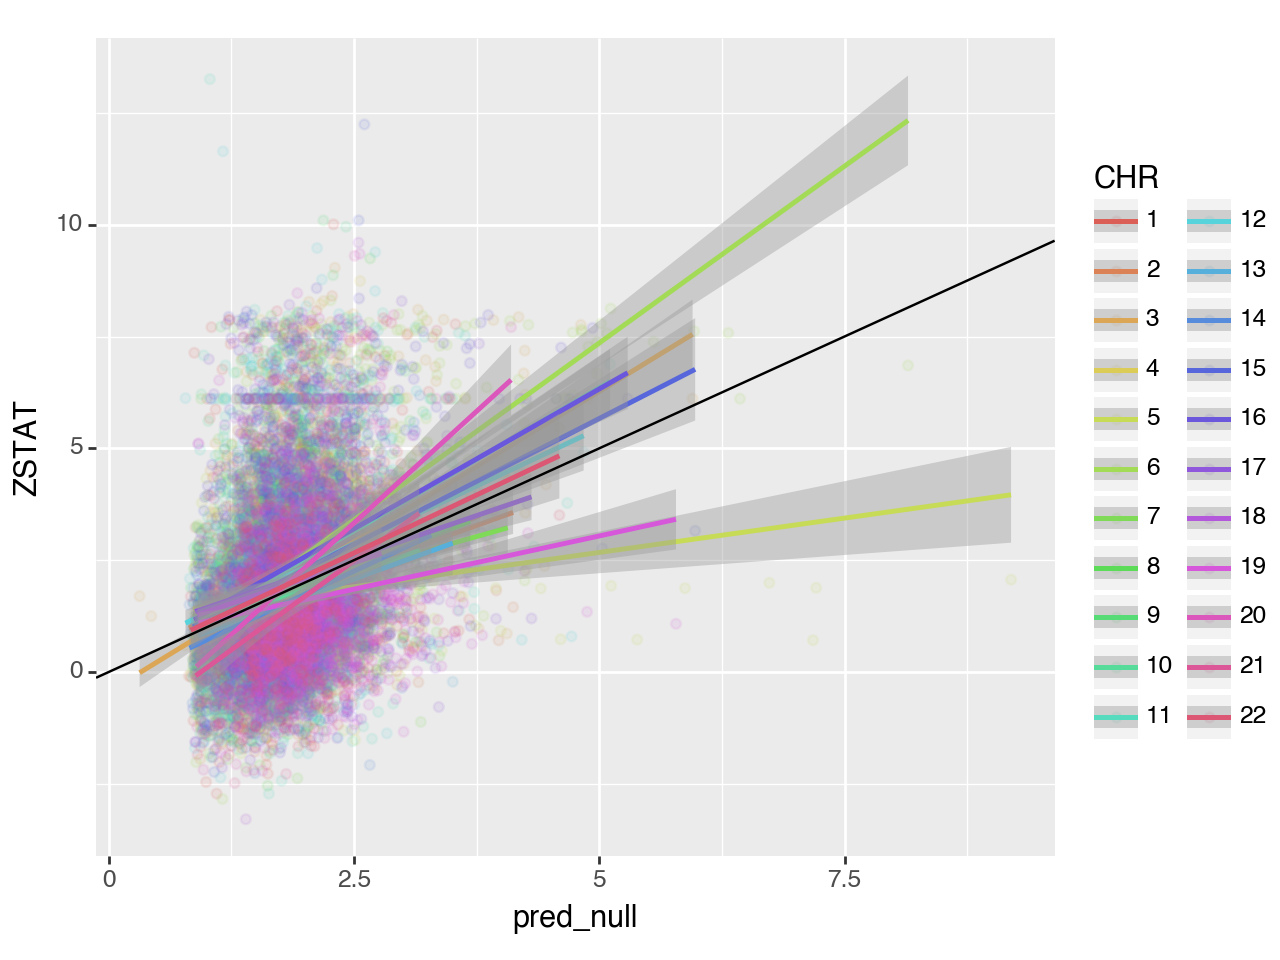

<Figure Size: (640 x 480)>

In [21]:
scatter(df, "pred_null", "ZSTAT", "pred_null", "ZSTAT", color = "CHR", smooth=True)

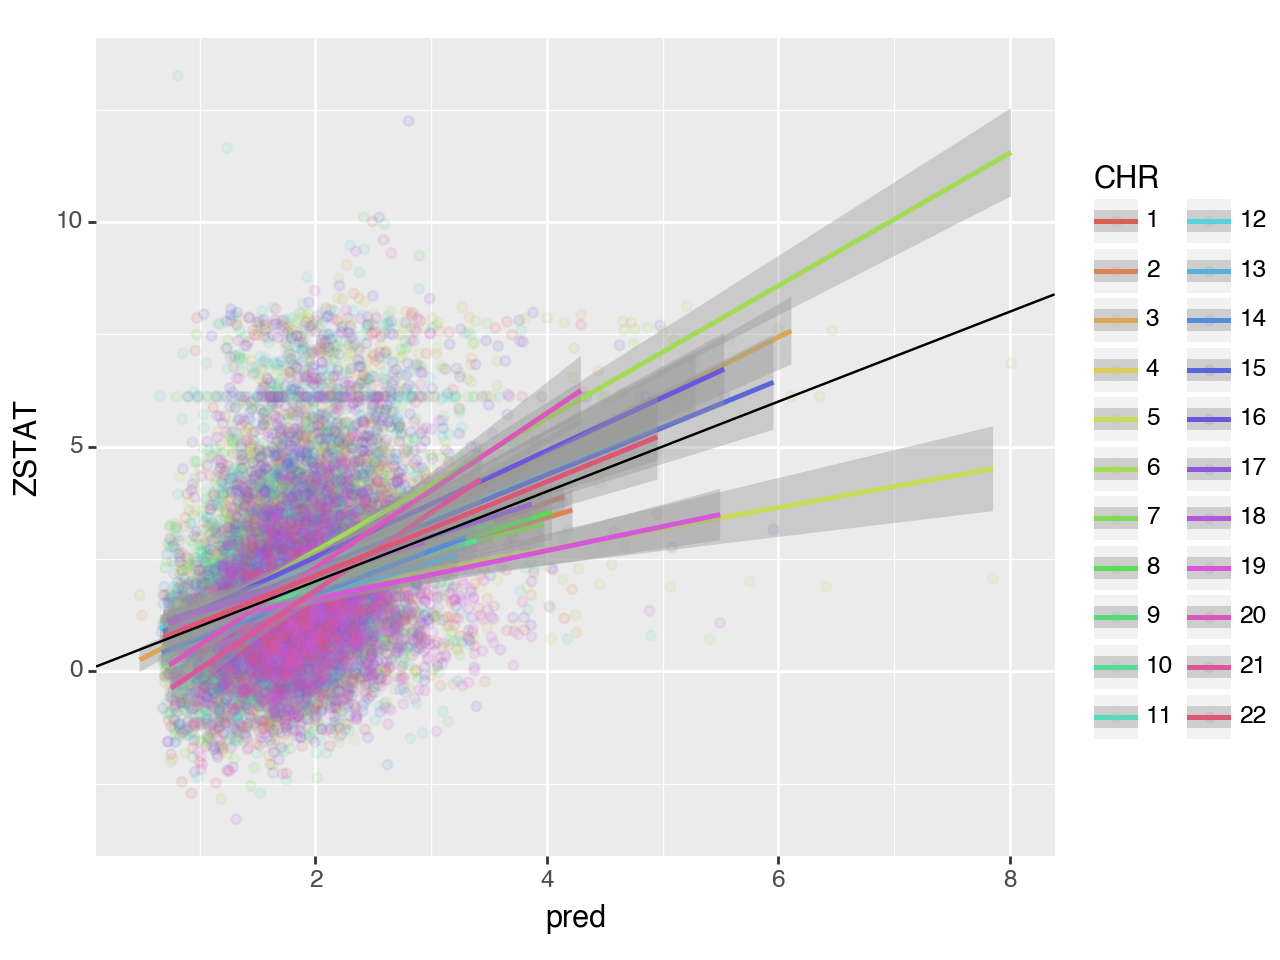

<Figure Size: (640 x 480)>

In [22]:
scatter(df, "pred", "ZSTAT", "pred", "ZSTAT", color = "CHR", smooth=True)

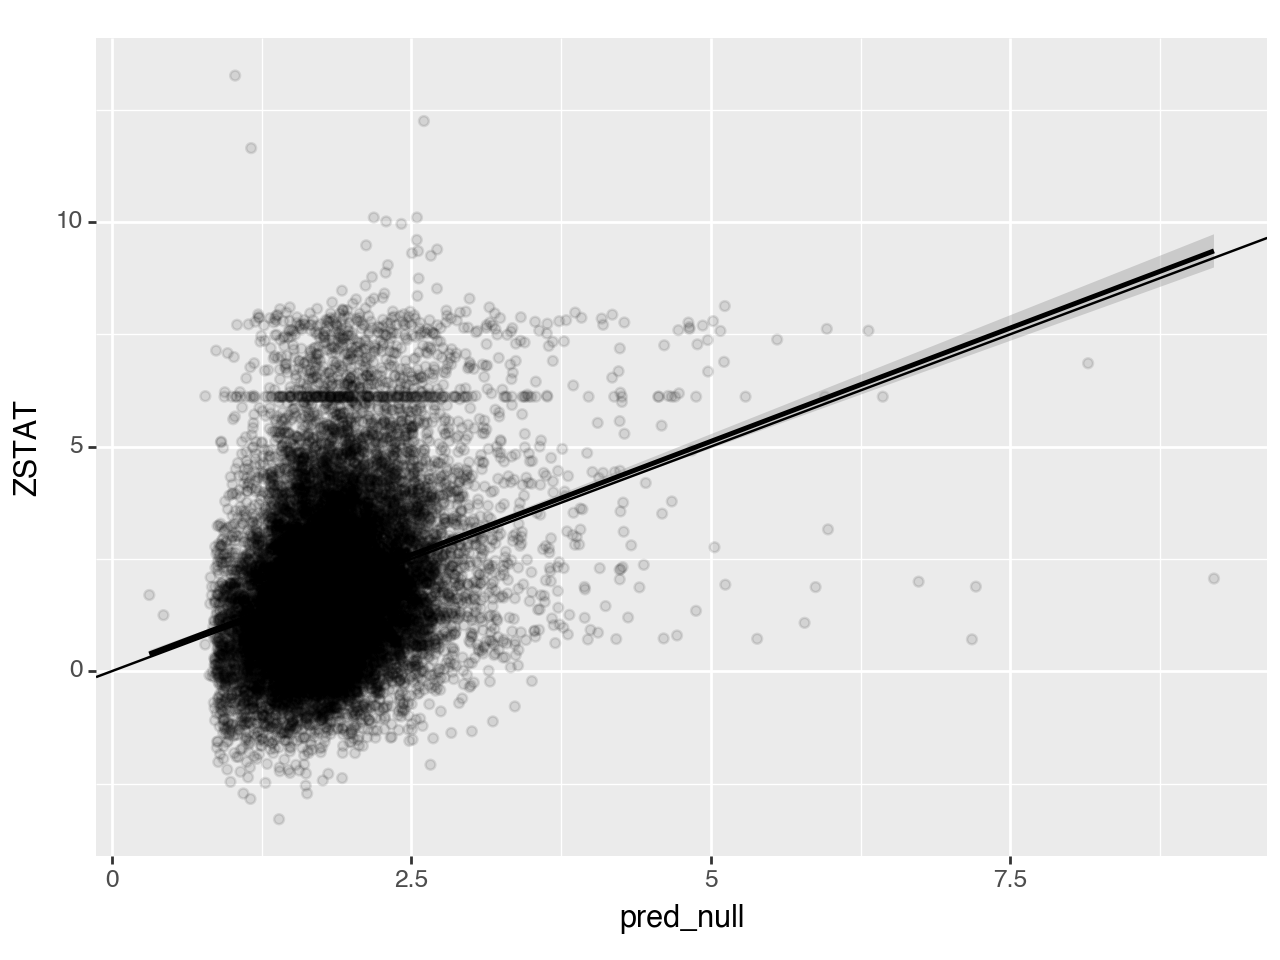

<Figure Size: (640 x 480)>

In [23]:
scatter(df, "pred_null", "ZSTAT", "pred_null", "ZSTAT", color = None, smooth=True)

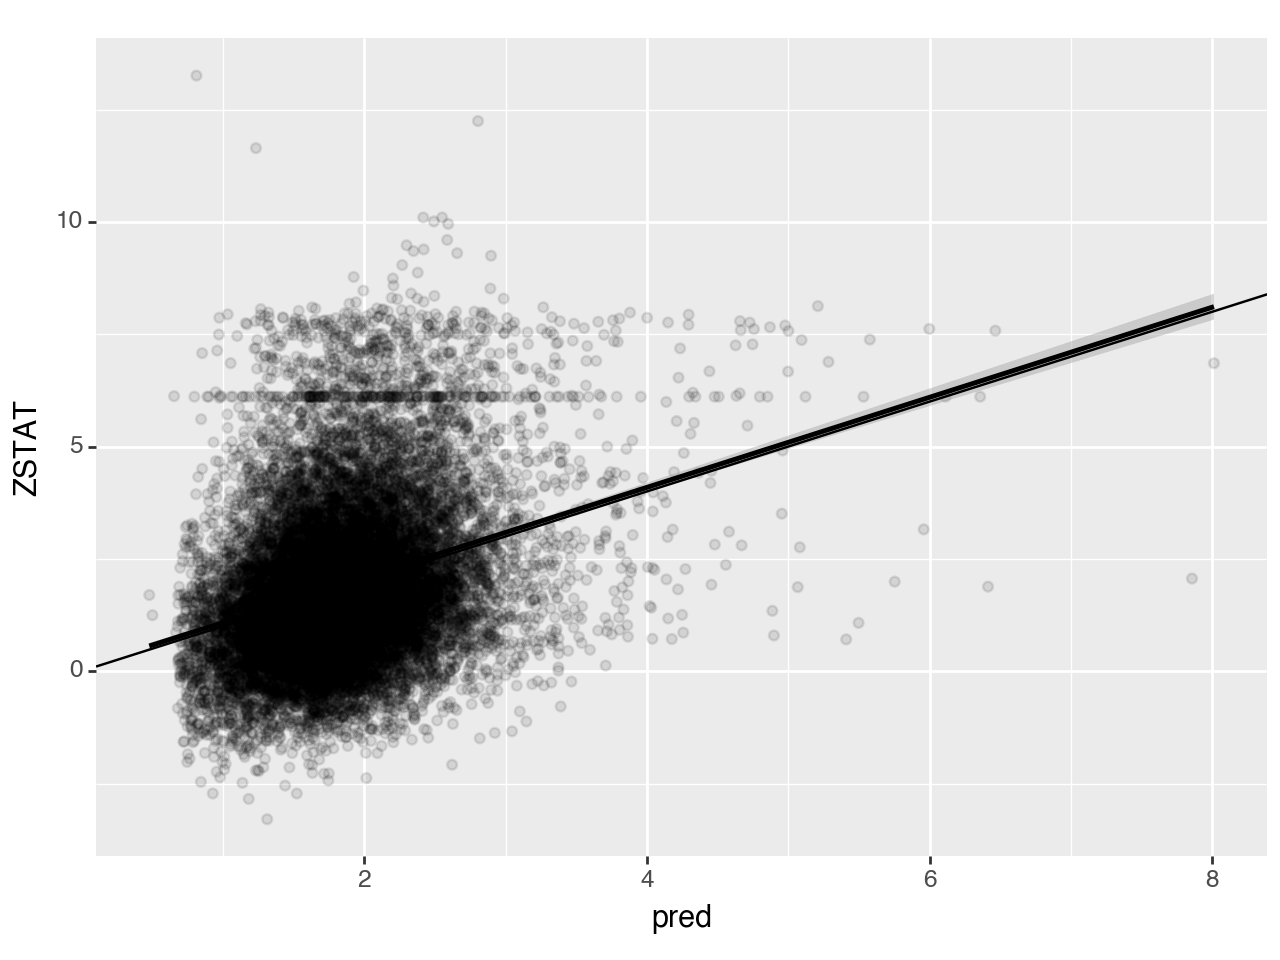

<Figure Size: (640 x 480)>

In [24]:
scatter(df, "pred", "ZSTAT", "pred", "ZSTAT", color = None, smooth=True)

In [25]:
#plot the r score
def plot_r2(dataframe=None, true = "ZSTAT", null = "pred_null", full="pred", r2_null=None, r2_full=None):
    if dataframe is not None:
        r2_null=[]
        r2_full=[]
        for i in range(1,23):
            df = dataframe.query("CHR == @i")
            r2_null.append(R2Score().update(torch.tensor(df[null].values), torch.tensor(df[true].values)).compute().numpy())
            r2_full.append(R2Score().update(torch.tensor(df[full].values), torch.tensor(df[true].values)).compute().numpy())
    r2 = pd.DataFrame({
        "r2_null": np.array(r2_null),
        "r2_full": np.array(r2_full),
        "r2_delta": (np.array(r2_full) - np.array(r2_null))})
    df1 = pd.melt(r2, value_vars=["r2_null", "r2_full"], var_name="model", value_name="r2")
    p1 = ggplot(df1, aes("model","r2")) + geom_boxplot()
    p2 = ggplot(r2, aes("r2_delta")) + geom_histogram()
    return p1, p2

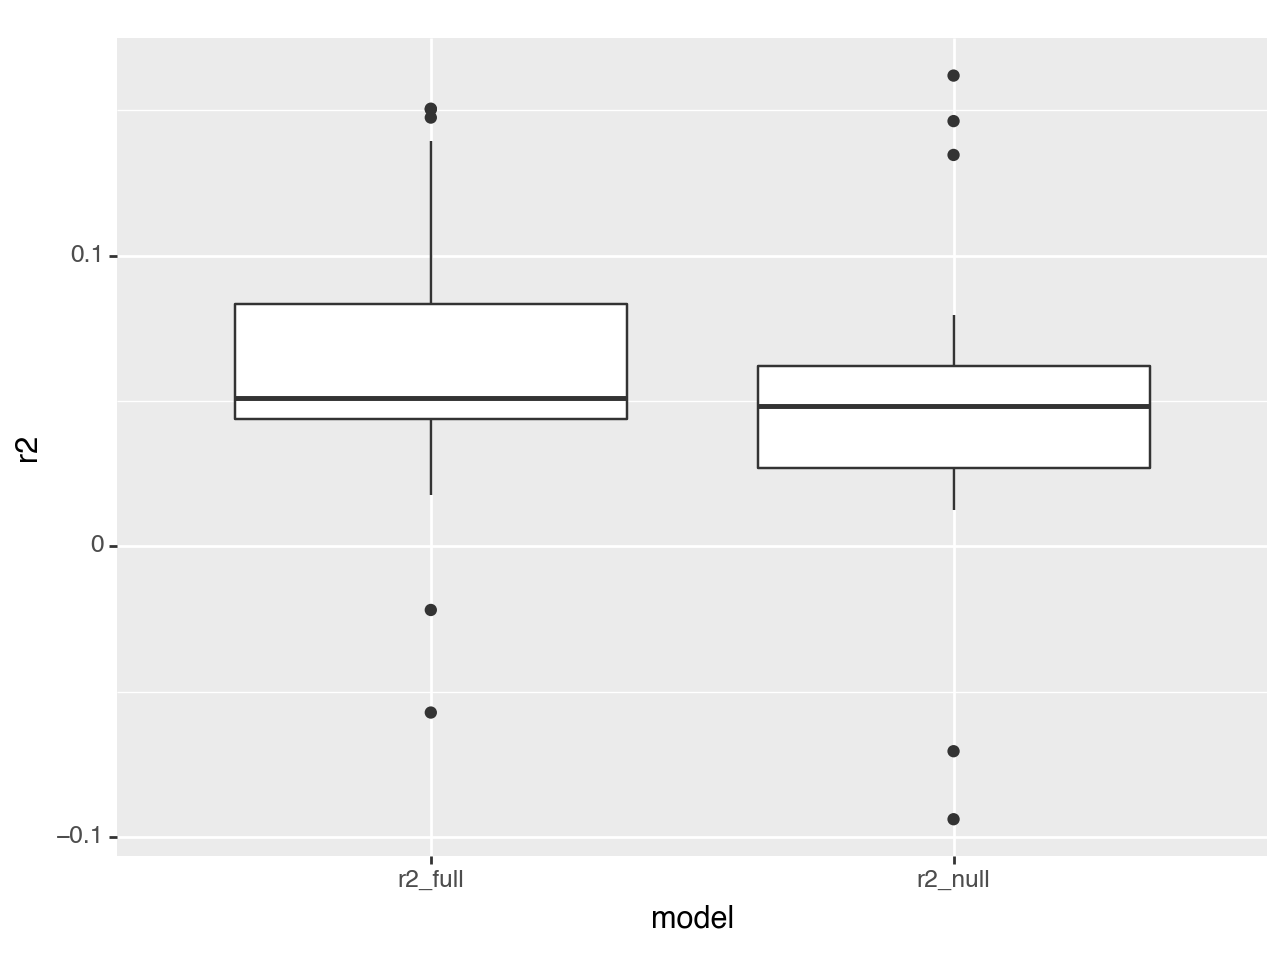

/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/plotnine/stats/stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 14'. Pick better value with 'binwidth'.


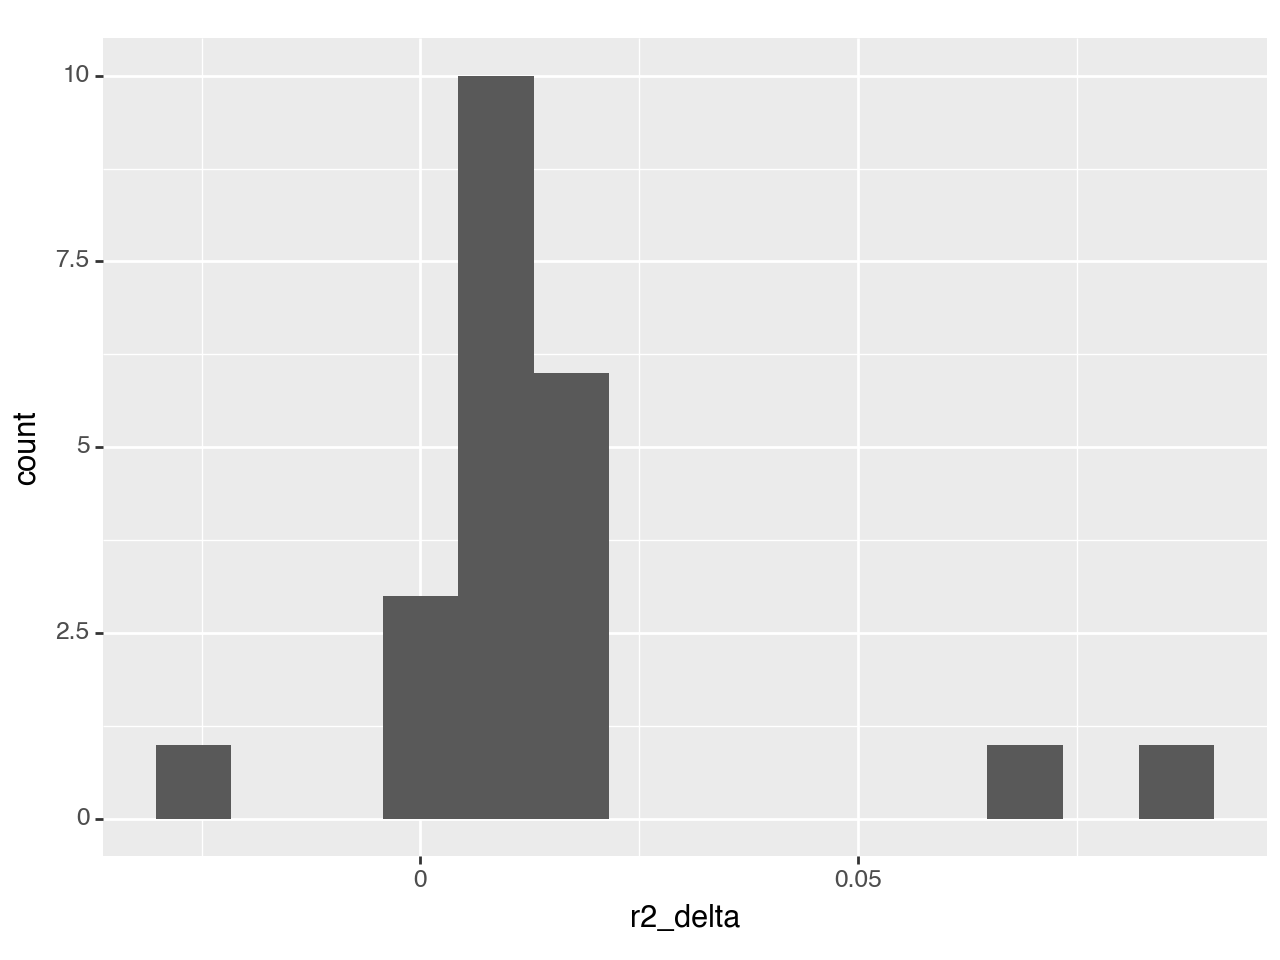

(<Figure Size: (640 x 480)>, <Figure Size: (640 x 480)>)

In [26]:
plot_r2(df)

## Regression by Linear Regressor


In [27]:
from sklearn.linear_model import LinearRegression

In [28]:
df = []

for chrom in range(1,23):
    reg_null = LinearRegression()
    reg_full = LinearRegression()
    
    # Null model (covariates only)
    mod_null = reg_null.fit(
        dt.query("CHR != @chrom").drop(["GENE", "CHR", "START", "STOP", "NSNPS", "NPARAM", "N", "ZSTAT", "P", "LY"], axis=1).drop(emb.columns.to_list(), axis=1),
        dt.query("CHR != @chrom")['LY']
    )
    pred_null = mod_null.predict(
        dt.query("CHR == @chrom").drop(["GENE", "CHR", "START", "STOP", "NSNPS", "NPARAM", "N", "ZSTAT", "P", "LY"], axis=1).drop(emb.columns.to_list(), axis=1),
    )
    
    # Full model
    mod_full = reg_full.fit(
        dt.query("CHR != @chrom").drop(["GENE", "CHR", "START", "STOP", "NSNPS", "NPARAM", "N", "ZSTAT", "P", "LY"], axis=1),
        dt.query("CHR != @chrom")['LY']
    )
    pred_full = mod_full.predict(
        dt.query("CHR == @chrom").drop(["GENE", "CHR", "START", "STOP", "NSNPS", "NPARAM", "N", "ZSTAT", "P", "LY"], axis=1),
    )

    df_chrom = dt.query("CHR == @chrom")[["GENE", "CHR", "START", "STOP", "NSNPS", "NPARAM", "N", "ZSTAT", "P", "LY"]]
    df_chrom['pred_LY_null'] = pred_null
    df_chrom['pred_LY'] = pred_full

    df.append(df_chrom)
    print(f"Chrom {chrom}: R2 (null): {scipy.stats.pearsonr(df_chrom.LY, df_chrom.pred_LY_null)[0]**2}")
    print(f"Chrom {chrom}: R2: {scipy.stats.pearsonr(df_chrom.LY, df_chrom.pred_LY)[0]**2}")

print()

df = pd.concat(df)
df = df.merge(project_Y_back(Ls, df))

print(f"Overall R2 (null): {scipy.stats.pearsonr(df.ZSTAT, df.pred_null)[0]**2}")
print(f"Overall R2: {scipy.stats.pearsonr(df.ZSTAT, df.pred)[0]**2}")

Chrom 1: R2 (null): 0.045740744300709305
Chrom 1: R2: 0.046174020011373586
Chrom 2: R2 (null): 0.10036185605018844
Chrom 2: R2: 0.1029978259293652
Chrom 3: R2 (null): 0.057604040529314136
Chrom 3: R2: 0.05738904562588123
Chrom 4: R2 (null): 0.048940083066864225
Chrom 4: R2: 0.025273897653351522
Chrom 5: R2 (null): 0.08006182056858727
Chrom 5: R2: 0.08131471199642964
Chrom 6: R2 (null): 0.027336435175438156
Chrom 6: R2: 0.025599431168935975
Chrom 7: R2 (null): 0.04535966798607934
Chrom 7: R2: 0.046878100000954846
Chrom 8: R2 (null): 0.07389124143009702
Chrom 8: R2: 0.07467085040092333
Chrom 9: R2 (null): 0.0568186005471721
Chrom 9: R2: 0.05943274593575185
Chrom 10: R2 (null): 0.07076580262097262
Chrom 10: R2: 0.07209994127043387
Chrom 11: R2 (null): 0.03699905004173823
Chrom 11: R2: 0.01506895959518142
Chrom 12: R2 (null): 0.030032224197267157
Chrom 12: R2: 0.02772961589650775
Chrom 13: R2 (null): 0.08216129129912225
Chrom 13: R2: 0.08422887844628918
Chrom 14: R2 (null): 0.0421311351866

In [29]:
print("Per chrom R2 (full):")

for i in range(1, 23):
    df_tmp = df.query("CHR == @i")

    print(scipy.stats.pearsonr(df_tmp.ZSTAT, df_tmp.pred)[0]**2)

Per chrom R2 (full):
0.04814036521237737
0.053533431225649325
0.15388971152702374
0.030276775116527054
0.024161434277480832
0.25544935245837697
0.035522942970666604
0.0678041235703223
0.06570185932152582
0.04930787449273664
0.05645333772159865
0.05214434402992567
0.05937295577336828
0.0686243099356821
0.10814498087093805
0.11803425817622126
0.04691641027962916
0.021608614111806992
0.016834439967430975
0.016306645936468685
0.1530631862924646
0.07167335257833173


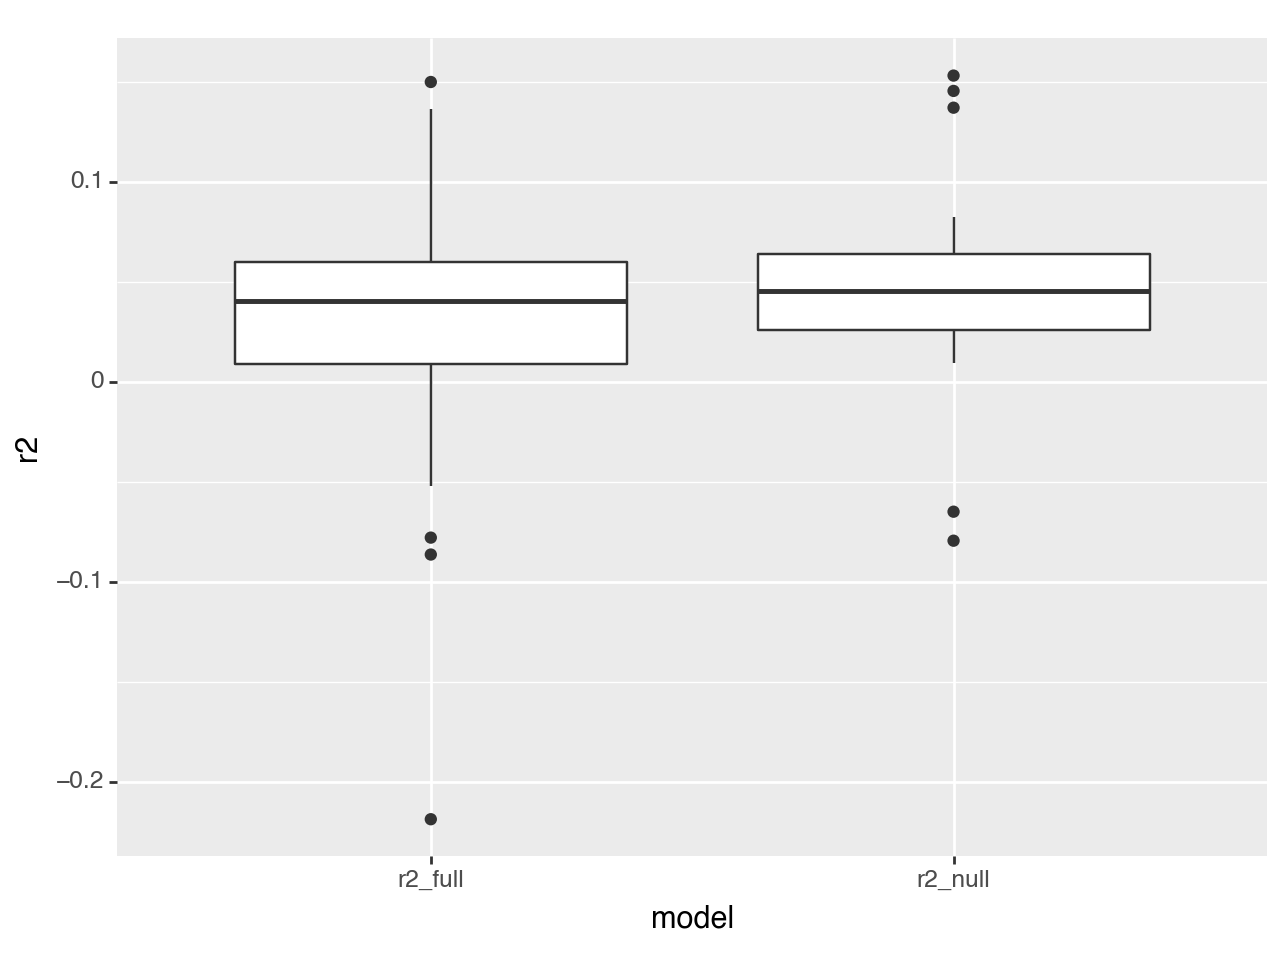

/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/plotnine/stats/stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 168'. Pick better value with 'binwidth'.


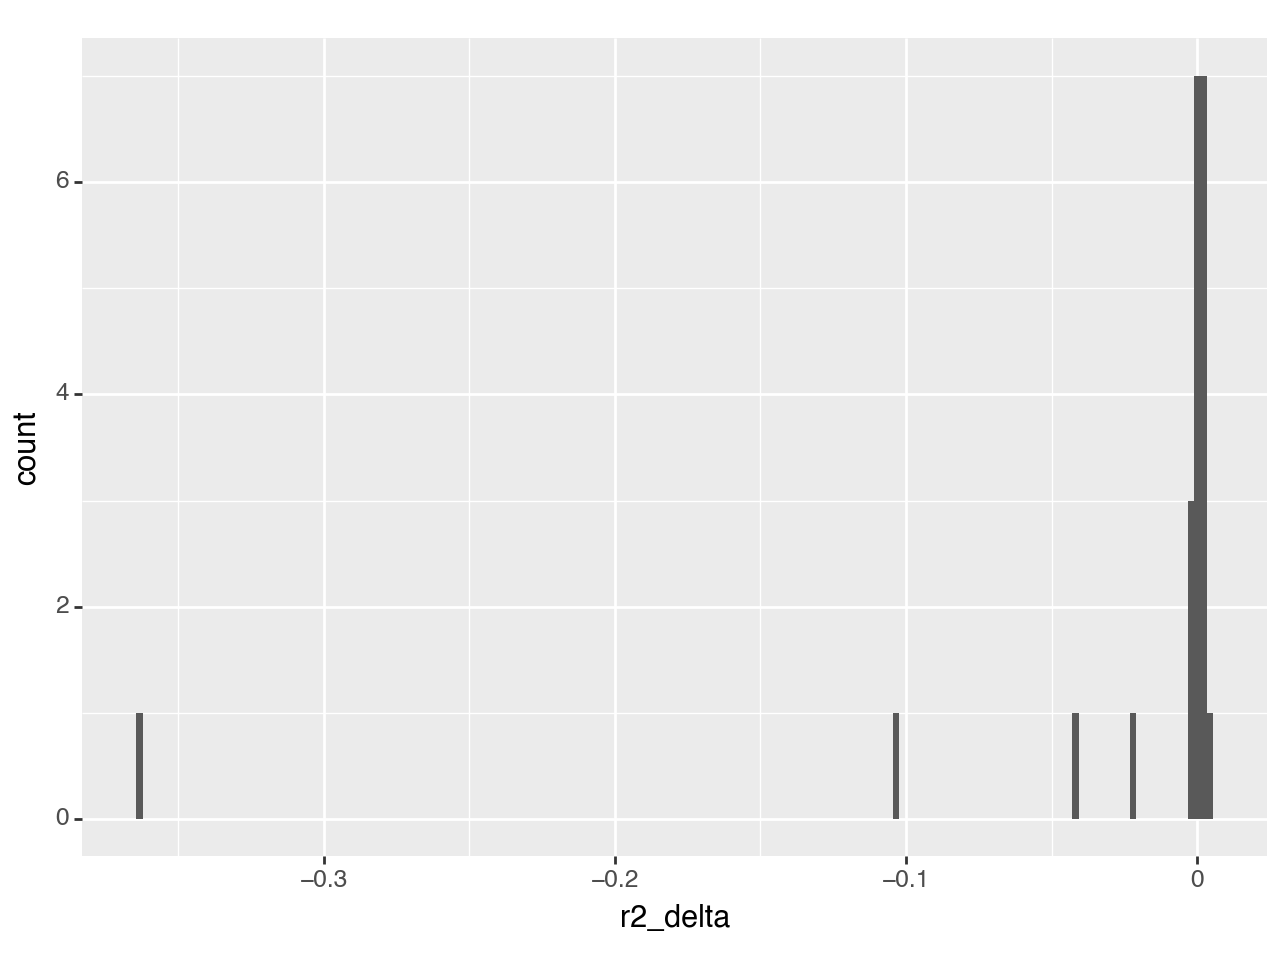

(<Figure Size: (640 x 480)>, <Figure Size: (640 x 480)>)

In [30]:
plot_r2(df)

## Regression by ElasticNet

In [31]:
from sklearn.linear_model import ElasticNetCV
from sklearn.model_selection import GroupKFold

In [32]:
df = []

for chrom in range(1,23):
    gkf = GroupKFold(n_splits=5)
    reg_null = ElasticNetCV(cv=gkf.split(dt.query("CHR != @chrom")['LY'], 
                                dt.query("CHR != @chrom")['LY'], 
                                groups = dt.query("CHR != @chrom")['CHR']),
                                random_state=0, fit_intercept=True)
    
    
    # Null model (covariates only)
    mod_null = reg_null.fit(
        dt.query("CHR != @chrom").drop(["GENE", "CHR", "START", "STOP", "NSNPS", "NPARAM", "N", "ZSTAT", "P", "LY"], axis=1).drop(emb.columns.to_list(), axis=1),
        dt.query("CHR != @chrom")['LY']
    )
    pred_null = mod_null.predict(
        dt.query("CHR == @chrom").drop(["GENE", "CHR", "START", "STOP", "NSNPS", "NPARAM", "N", "ZSTAT", "P", "LY"], axis=1).drop(emb.columns.to_list(), axis=1),
    )
    
    gkf = GroupKFold(n_splits=5)
    reg_full = ElasticNetCV(cv=gkf.split(dt.query("CHR != @chrom")['LY'], 
                                dt.query("CHR != @chrom")['LY'], 
                                groups = dt.query("CHR != @chrom")['CHR']),
                                random_state=0, fit_intercept=True)
    # Full model
    mod_full = reg_full.fit(
        dt.query("CHR != @chrom").drop(["GENE", "CHR", "START", "STOP", "NSNPS", "NPARAM", "N", "ZSTAT", "P", "LY"], axis=1),
        dt.query("CHR != @chrom")['LY']
    )
    pred_full = mod_full.predict(
        dt.query("CHR == @chrom").drop(["GENE", "CHR", "START", "STOP", "NSNPS", "NPARAM", "N", "ZSTAT", "P", "LY"], axis=1),
    )

    df_chrom = dt.query("CHR == @chrom")[["GENE", "CHR", "START", "STOP", "NSNPS", "NPARAM", "N", "ZSTAT", "P", "LY"]]
    df_chrom['pred_LY_null'] = pred_null
    df_chrom['pred_LY'] = pred_full

    df.append(df_chrom)
    print(f"Chrom {chrom}: R2 (null): {scipy.stats.pearsonr(df_chrom.LY, df_chrom.pred_LY_null)[0]**2}")
    print(f"Chrom {chrom}: R2: {scipy.stats.pearsonr(df_chrom.LY, df_chrom.pred_LY)[0]**2}")

print()

df = pd.concat(df)
df = df.merge(project_Y_back(Ls, df))

print(f"Overall R2 (null): {scipy.stats.pearsonr(df.ZSTAT, df.pred_null)[0]**2}")
print(f"Overall R2: {scipy.stats.pearsonr(df.ZSTAT, df.pred)[0]**2}")

Chrom 1: R2 (null): 0.046699923028868606
Chrom 1: R2: 0.04734279921131888
Chrom 2: R2 (null): 0.10192588264224063
Chrom 2: R2: 0.10353460384347389
Chrom 3: R2 (null): 0.054483487542181123
Chrom 3: R2: 0.054619362669896615
Chrom 4: R2 (null): 0.04876405668875193
Chrom 4: R2: 0.04542480226568005
Chrom 5: R2 (null): 0.08290706252482136
Chrom 5: R2: 0.08289658499879088
Chrom 6: R2 (null): 0.02696143030963343
Chrom 6: R2: 0.026297868519181002
Chrom 7: R2 (null): 0.04391216790169356
Chrom 7: R2: 0.04206745232279338
Chrom 8: R2 (null): 0.07278727603884456
Chrom 8: R2: 0.07366074480978872
Chrom 9: R2 (null): 0.06162003620212278
Chrom 9: R2: 0.062102700113165606
Chrom 10: R2 (null): 0.07109191986171534
Chrom 10: R2: 0.07258775034987391
Chrom 11: R2 (null): 0.035230153670810005
Chrom 11: R2: 0.03576805945090288
Chrom 12: R2 (null): 0.02999177967697579
Chrom 12: R2: 0.029454008205718484
Chrom 13: R2 (null): 0.07880634277702603
Chrom 13: R2: 0.08127757639821868
Chrom 14: R2 (null): 0.0402463057675

In [33]:
print("Per chrom R2 (full):")

for i in range(1, 23):
    df_tmp = df.query("CHR == @i")

    print(scipy.stats.pearsonr(df_tmp.ZSTAT, df_tmp.pred)[0]**2)

Per chrom R2 (full):
0.048367679409094914
0.05380237731141602
0.15124011696042688
0.048236588241239275
0.02305165375580024
0.2582870832800703
0.03051515913491724
0.06683519096348729
0.06682921092886819
0.0483693749221809
0.0868277938092668
0.05349948849689007
0.0564297211759846
0.06653086226172773
0.1031433982932664
0.12488272581226446
0.04339999241824145
0.02100184699736307
0.016410105433739604
0.18561928711435885
0.1766759308626882
0.07280452167992756


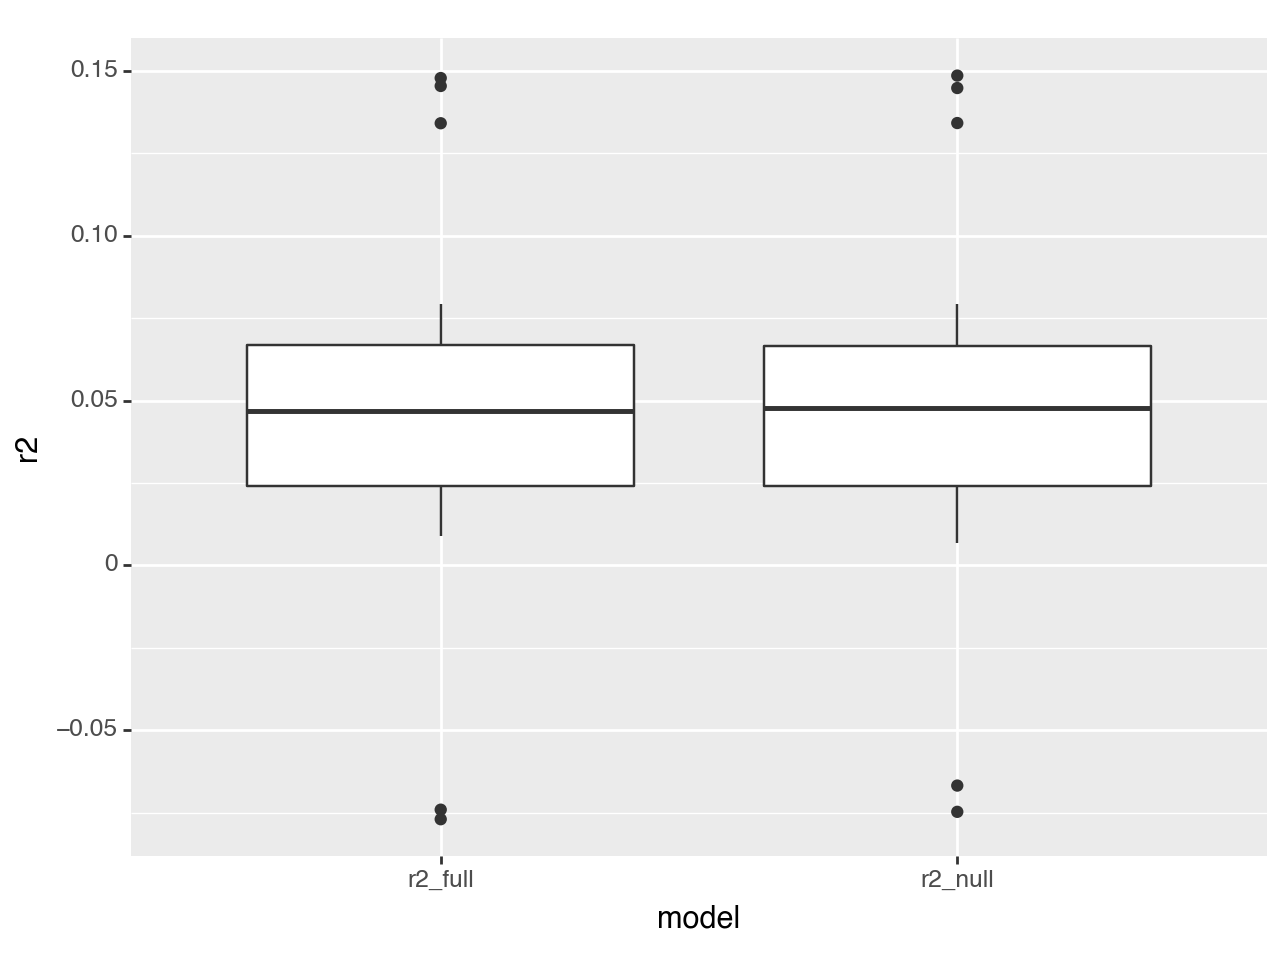

/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/plotnine/stats/stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 23'. Pick better value with 'binwidth'.


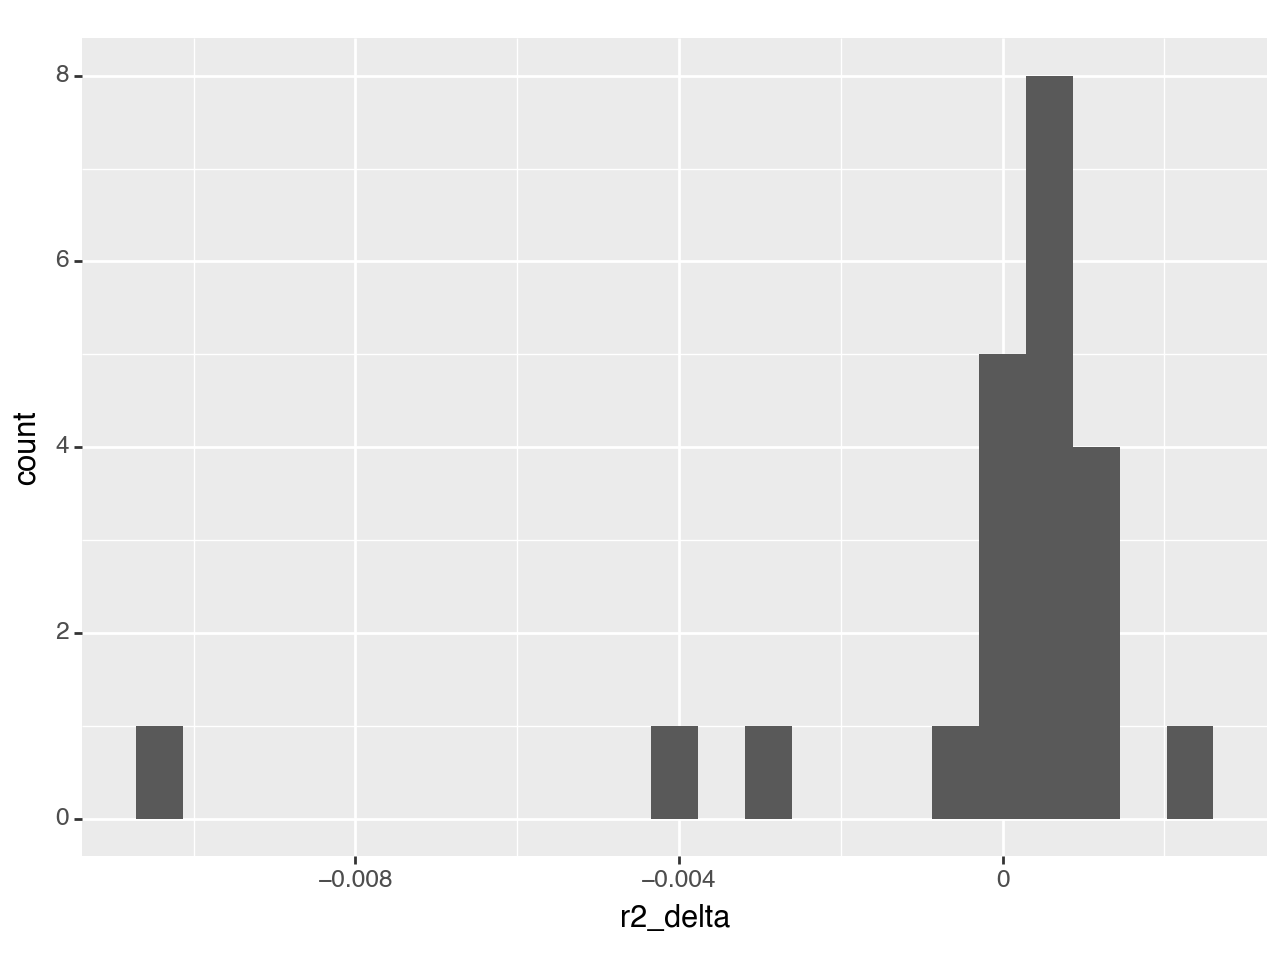

(<Figure Size: (640 x 480)>, <Figure Size: (640 x 480)>)

In [34]:
plot_r2(df)